In [413]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label
from flask import Flask, jsonify
from datetime import datetime

In [260]:
# create engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [262]:
# save to ORM tables
measrm = Base.classes.measurements
stations = Base.classes.stations

In [263]:
# bind session
session = Session(bind = engine)

In [264]:
# inspector to get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [265]:
# list for names of columns
col = inspector.get_columns("stations")
for col in col:
    print(col["name"], col["type"])

id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [266]:
# list for names of columns
col = inspector.get_columns("measurements")
for col in col:
    print(col["name"], col["type"])

id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs FLOAT


In [267]:
engine.execute("SELECT * FROM stations LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [268]:
engine.execute("SELECT * FROM measurements LIMIT 5").fetchall()

[(1, 'USC00519397', '1/1/10', 0.08, 65.0),
 (2, 'USC00519397', '1/2/10', 0.0, 63.0),
 (3, 'USC00519397', '1/3/10', 0.0, 74.0),
 (4, 'USC00519397', '1/4/10', 0.0, 76.0),
 (5, 'USC00519397', '1/7/10', 0.06, 70.0)]

In [269]:
# PRECIPITATION ANALYSIS
# get last date in the table
last = session.query(measrm.date).order_by(measrm.date.desc()).first()
print(last)

('9/9/16',)


In [270]:
# get last 12mo (subtract 365 days using timedelta)
lastyr = dt.date(2016, 9, 9) - dt.timedelta(days=365)
print(lastyr)

2015-09-10


In [271]:
# precip data of last year
precipit = session.query(measrm.date, measrm.prcp).\
    filter(measrm.date > lastyr).\
    order_by(measrm.date).all()

In [272]:
# precip data to df
precipit_df = pd.DataFrame(precipit)
precipit_df.head()

,date,prcp
0,3/1/10,0.01
1,3/1/10,0.12
2,3/1/10,0.01
3,3/1/10,0.12
4,3/1/10,0.01


In [454]:
# reset index to "date"
precipit_df.set_index("date").head()

,prcp
date,
3/1/10,0.01
3/1/10,0.12
3/1/10,0.01
3/1/10,0.12
3/1/10,0.01


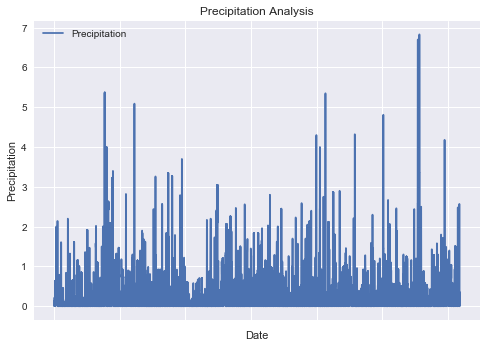

In [283]:
# plot df
precipit_df.plot("date", "prcp")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.show()

In [284]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe().round(2)

,prcp
count,4122.00
mean,0.35
std,0.63
min,0.00
25%,0.00
50%,0.08
75%,0.42
max,6.83


In [285]:
# STATION ANALYSIS
# find number of stations
locs = session.query(measrm).group_by(measrm.station).count()
locs

3

In [289]:
# most active stations with most temperature observations
active_st = session.query(measrm.station, func.count(measrm.tobs)).group_by(measrm.station).\
order_by(func.count(measrm.tobs).desc()).all()
active_st

[('USC00516128', 7452), ('USC00519397', 2646), ('USC00511918', 93)]

In [290]:
# busiest station
most_active = active_st[0][0]
most_active  

'USC00516128'

In [381]:
# retrieve last 12 mo of temp observation data (tobs)
temp = session.query(measrm.station, measrm.date, measrm.tobs).\
filter(measrm.station == most_active).\
filter(measrm.date > lastyr).\
order_by(measrm.date).all()
#temp

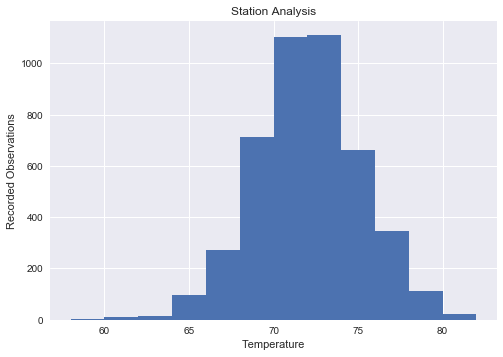

In [368]:
# plot observations with bins = 12
temp_df = pd.DataFrame(temp)
plt.hist(temp_df["tobs"], 12)
plt.xlabel("Temperature")
plt.ylabel("Recorded Observations")
plt.title("Station Analysis")
plt.show()

In [505]:
# TEMPERATURE ANALYSIS
# find average, min, max of temperatures
def calc_temps(arrivedt, leavedt):
  
    return session.query(func.min(measrm.tobs), func.avg(measrm.tobs), func.max(measrm.tobs)).\
        filter(measrm.date >= arrivedt).filter(measrm.date <= leavedt).all()
trip_temp = (calc_temps("9/10/14", "9/13/14"))
print(trip_temp)

[(70.0, 74.125, 85.0)]


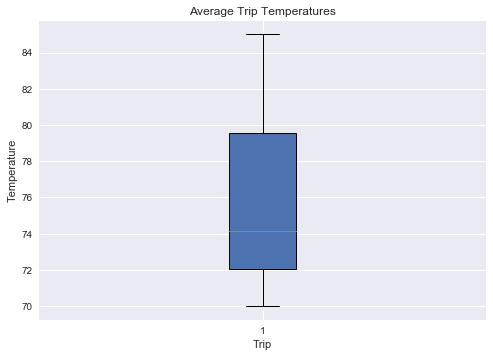

In [507]:
# plot temp data
fig, ax = plt.subplots()
xval = range(len(trip_temp))
ax.boxplot(trip_temp, patch_artist=True)
ax.set_title("Average Trip Temperatures")
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
plt.show()